In [3]:
from collections import defaultdict
import random
import numpy as np
import matplotlib.pyplot as plt

import time
from tqdm import tqdm 
import multiprocessing

# import gymnasium as gym
import gym
import gym_examples
from gym.wrappers import FlattenObservation

from algos import *
from utils import *

In [5]:

random.seed(123)
np.random.seed(123)
tdqm_disable = True

# params
env_id = "gym_examples/GridWorld-v1"
gridworld_size = 3
max_steps = 20
gamma = 0.95

num_trials = 1000
num_episodes_train = 1000
num_episodes_eval = 100

lr_sched_type = "poly"
lr_sched_fn = create_lr_sched_fn(lr_sched_type)

max_eps = 1.0
min_eps = 0.05
decay_rate = 0.0005
eps_sched_type = "poly"
eps_sched_fn = create_eps_sched_fn(eps_sched_type, min_eps, max_eps, decay_rate)

haver_const = 20.0
est_name = "haver" 
q_algo_name = "haver_q_learning"
q_algo = create_q_algo(q_algo_name)

# create gym env
env = gym.make(env_id, size=gridworld_size)
env_wrapped = FlattenObservation(env)
num_actions = env_wrapped.action_space.n
# print(f"num_actions = {num_actions}")
# print(env_wrapped.reset())
# stop

manager = multiprocessing.Manager()
episode_lengths_list = manager.list()
episode_rewards_list = manager.list()
episode_start_vals_list = manager.list()

def run_trial(i_trial, args):
    
    random.seed(10000+i_trial)
    np.random.seed(10000+i_trial)

    env = gym.make(env_id, size=gridworld_size)
    env_wrapped = FlattenObservation(env)
    # env_wrapped.reset(seed=10000+i_trial)
    
    lr_sched_fn = create_lr_sched_fn(args["lr_sched_type"])
    eps_sched_fn = create_eps_sched_fn(eps_sched_type, min_eps, max_eps, decay_rate)
    q_algo = create_q_algo(q_algo_name)
    
    # init Q_table, Q_nvisits
    Q_table = defaultdict(lambda: np.zeros(num_actions))
    Q_nvisits = defaultdict(lambda: np.zeros(num_actions))
    Q_table, stats = q_algo(
        env_wrapped, Q_table, Q_nvisits, num_episodes_train, max_steps,
        gamma, lr_sched_fn, eps_sched_fn, tdqm_disable, args)
    
    episode_lengths, episode_rewards, episode_start_vals= zip(*stats)
    episode_lengths_list.append(episode_lengths)
    episode_rewards_list.append(episode_rewards)
    episode_start_vals_list.append(episode_start_vals)

episode_lengths_mean_dict = defaultdict()
episode_rewards_mean_dict = defaultdict()
episode_start_vals_mean_dict = defaultdict()

args = dict()
pool = multiprocessing.Pool()

lr_sched_types = ["linear", "poly"]
for lr_sched_type in lr_sched_types:
    start_time = time.time()
    print(f"\n-> lr_sched_type = {lr_sched_type}")
    print(f"haver_const = {haver_const}")
    args["lr_sched_type"] = lr_sched_type
    args["haver_const"] = haver_const
        
    pool.starmap(run_trial, [(i, args) for i in range(num_trials)])

    episode_lengths_ary = np.hstack([episode_lengths_list])
    episode_rewards_ary = np.hstack([episode_rewards_list])
    episode_start_vals_ary = np.hstack([episode_start_vals_list])

    episode_lengths_mean_dict[lr_sched_type] = np.mean(episode_lengths_ary, 0)
    episode_rewards_mean_dict[lr_sched_type] = np.mean(episode_rewards_ary, 0)
    episode_start_vals_mean_dict[lr_sched_type] = np.mean(episode_start_vals_ary, 0)
    print(f"last_episode_length = {episode_lengths_mean_dict[lr_sched_type][-1]}")
    print(f"last_episode_reward_per_step = {episode_rewards_mean_dict[lr_sched_type][-1]:.4f}")
    print(f"last_episode_estim_start_val = {episode_start_vals_mean_dict[lr_sched_type][-1]:.4f}")
    
    episode_lengths_list[:] = []
    episode_rewards_list[:] = []
    episode_start_vals_list[:] = []
    
    end_time = time.time()
    print(f"it takes {end_time-start_time}")


-> lr_sched_type = linear
haver_const = 20.0
last_episode_length = 6.943
last_episode_reward_per_step = 0.2678
last_episode_estim_start_val = -3.8003
it takes 144.79084300994873

-> lr_sched_type = poly
haver_const = 20.0
last_episode_length = 4.188
last_episode_reward_per_step = 0.8160
last_episode_estim_start_val = -5.5997
it takes 85.5785403251648


In [3]:
# for i_trial in range(num_trials):
#     last_episode_length = episode_lengths_list[i_trial,-1]
#     if episode_lengths_list[i_trial,-1] > 4:
#         print(i_trial, last_episode_length)
print(episode_lengths_ary[:100,-1])

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 4 4 4 4 4 4 4
 4 4 4 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 5 4 6 4 4 4 4 4 4 5 4 4 5 4 4 4]


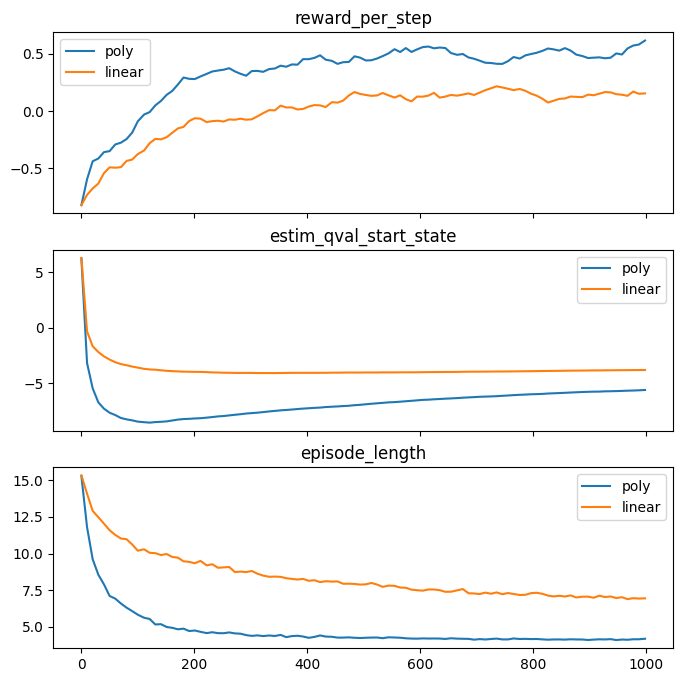

In [6]:
fig, axes = fig, axes = plt.subplots(
        nrows=3, ncols=1, sharex=True, sharey=False, figsize=(8,8))
# axes = [axes]

x_ary = np.linspace(0, num_episodes_train-1, num=100, dtype=np.int32)
lr_sched_types = ["poly", "linear"]
for lr_sched_type in lr_sched_types:
    y_ary = running_avg(episode_rewards_mean_dict[lr_sched_type][x_ary], 10)
    axes[0].plot(
        x_ary, y_ary, label=lr_sched_type)
    # axes[0].plot(x_ary, episode_rewards_mean[x_ary], label=lr_sched_type)
    axes[1].plot(x_ary, episode_start_vals_mean_dict[lr_sched_type][x_ary], label=lr_sched_type)
    axes[2].plot(x_ary, episode_lengths_mean_dict[lr_sched_type][x_ary], label=lr_sched_type)

axes[0].set_title("reward_per_step")
axes[1].set_title("estim_qval_start_state")
axes[2].set_title("episode_length")
axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.show()